In [1]:
from torch_src.alexnet import AlexNet
import torch
from torchvision import transforms

In [2]:
alex_net = AlexNet()
alex_net

AlexNet(
  (block_left_first): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_left_second): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (block_left_third): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
    (2): ReLU()
  )
  (block_left_fo

In [3]:
alex_net(torch.randn(size=(2, 3, 227, 227))).sum(dim=1)

tensor([0.4469, 0.2010], grad_fn=<SumBackward1>)

In [4]:
from torch.utils.data import DataLoader
from torch_src.data import CarDataset

In [5]:


transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float64),
    transforms.Resize(size=(227, 227))
])

dataset = CarDataset(root='data/LR1-1/', img_folder='cars_train', transform=transform)

train_dataset, test_dataset = dataset.split_dataset(train_part=0.8)
train_dataloader, test_dataloader = DataLoader(dataset, batch_size=4, shuffle=True), DataLoader(test_dataset, batch_size=4)

In [6]:
from mat4py import loadmat
import os
anno = loadmat(os.path.join('C:\\MySpace\\Projects\\PTDL\\lab1\\data\\LR1-1', 'cars_meta.mat'))
class_names = anno['class_names']

Audi V8 Sedan 1994


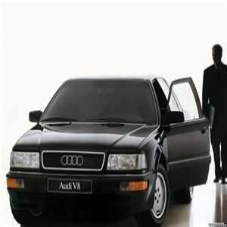

In [7]:
from PIL import Image
import numpy as np

imgs, targets = list(next(iter(train_dataloader)))
img = imgs[0]
target = targets[0]
img = torch.permute(img, (1, 2, 0)).detach().cpu().numpy()
print(class_names[target])
Image.fromarray((img * 255).astype(np.uint8))

In [8]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

loss = FocalLoss()

In [9]:
# from torchvision.models import resnet50, ResNet50_Weights
# del alex_net
# resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).eval()
# resnet50.fc = torch.nn.Linear(in_features=2048, out_features=196, bias=True)

In [10]:

import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
counter = {i: 0 for i in range(196)}
from torch.optim import Adam
from torch_src.optim import AdaSmooth

def train(model: torch.nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer, criterion, epochs: int = 10):
    device = torch.device('cuda')
    model.to(device)
    epoch_loss = list()

    for e in range(epochs):
        with tqdm(total=len(train_loader)) as t:
            full_loss = 0
            model.train()
            for i, data in enumerate(train_loader):
                batch, targets = data
                for target in targets:
                    counter[int(target.numpy())] += 1
                targets = targets.to(device)
                batch = batch.to(dtype=torch.float)
                batch = batch.to(device=device)
                out = model(batch)
                output = F.softmax(out, dim=1)
                optimizer.zero_grad()
                loss = criterion(output, targets)
                full_loss += loss.item()
                epoch_loss.append(loss.item())
                loss.backward()
                optimizer.step()

                t.update(1)
                t.set_postfix_str(f'Epoch: {e + 1} | Loss: loss: {full_loss / (i + 1)}')

        with tqdm(total=len(test_loader)) as t:
            model.eval()
            labels, predictions = list(), list()
            for i, (img, label) in enumerate(test_loader):
                labels.extend(label.detach().cpu().tolist())
                img = img.to(device=device, dtype=torch.float)
                output = model(img)
                output = F.softmax(output, dim=1)
                predictions.extend(torch.argmax(output, dim=1).detach().cpu().tolist())
                t.update(1)

            print(f'Accuracy: {100 * accuracy_score(labels, predictions)}%')
    return epoch_loss

In [11]:
# from torch.nn import CrossEntropyLoss
#
# criterion = CrossEntropyLoss()

In [12]:
epoch_loss_adam = train(model=alex_net, train_loader=train_dataloader, test_loader=test_dataloader, optimizer=Adam(params=alex_net.parameters(), lr=0.001, weight_decay=5e-5), criterion=loss, epochs=1)

100%|██████████| 408/408 [00:25<00:00, 15.91it/s]

Accuracy: 0.9208103130755065%


In [13]:
del alex_net
alex_net = AlexNet()
train_dataloader, test_dataloader = DataLoader(dataset, batch_size=4, shuffle=True), DataLoader(test_dataset, batch_size=4)
epoch_loss_adasmooth = train(model=alex_net, train_loader=train_dataloader, test_loader=test_dataloader, optimizer=AdaSmooth(params=alex_net.parameters(), lr=0.001, window=5), criterion=loss, epochs=1)

100%|██████████| 408/408 [00:25<00:00, 15.97it/s]

Accuracy: 0.3069367710251688%


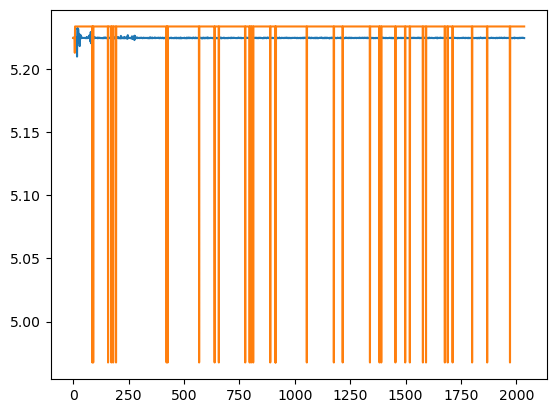

In [19]:
from matplotlib import pyplot as plt

plt.plot(range(len(epoch_loss_adam)), epoch_loss_adam)
plt.plot(range(len(epoch_loss_adam)) , epoch_loss_adasmooth)
plt.show()